Found 127989 potential blobs before filtering
After filtering: 22565 sunflower blobs
After duplicate removal: 1100 sunflowers

σ range used: 2 to 20

Top 5 largest sunflowers:
Rank | Center (x,y) | Radius | Response
---------------------------------------------
   1 | (358.0, 179.0) |   28.3 | 0.6216
   2 | (339.0, 179.0) |   28.3 | 0.5991
   3 | (317.0, 179.0) |   28.3 | 0.5084
   4 | (209.0, 187.0) |   28.3 | 0.4550
   5 | (  1.0, 196.0) |   28.3 | 0.3925


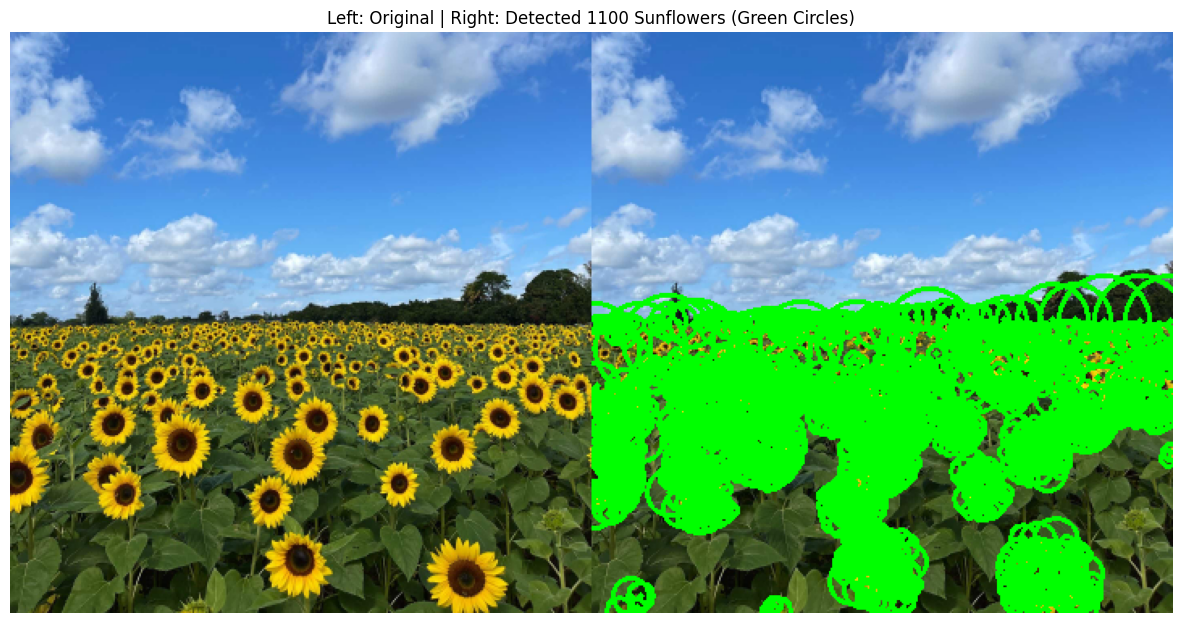


Filtering Statistics:
Total blobs detected: 127989
Removed by sky filter: 8234
Removed by size filter: 16401
Removed by contrast filter: 2366
Removed by color filter: 94288
Final sunflowers: 1100


In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
gray = gray.astype(np.float32) / 255.0

# Define scale space parameters
sigma_start = 2
sigma_end = 20
num_scales = 10
sigma_values = np.linspace(sigma_start, sigma_end, num_scales)

# Create scale-space (LoG responses)
h, w = gray.shape
log_response = np.zeros((h, w, num_scales), dtype=np.float32)

for i, sigma in enumerate(sigma_values):
    # Apply Gaussian Blur
    ksize = int(6 * sigma + 1)
    blur = cv.GaussianBlur(gray, (ksize, ksize), sigma)
    
    # Laplacian of Gaussian approximation
    log = cv.Laplacian(blur, cv.CV_32F, ksize=3)
    
    # Normalize scale (multiply by sigma^2)
    log_response[:, :, i] = (sigma ** 2) * np.abs(log)

# Find scale-space maxima
max_resp = np.max(log_response, axis=2)
threshold = 0.03  # Tune based on image contrast

blobs = []
for y in range(1, h - 1):
    for x in range(1, w - 1):
        val = max_resp[y, x]
        if val > threshold:
            scale_idx = np.argmax(log_response[y, x, :])
            sigma = sigma_values[scale_idx]
            blobs.append((x, y, sigma, val))  # Store response value too

# FILTERING STRATEGY FOR SUNFLOWERS ONLY
print(f"Found {len(blobs)} potential blobs before filtering")

# Convert to HSV for color-based filtering
hsv = cv.cvtColor(im, cv.COLOR_BGR2HSV)

# Strategy 1: Remove blobs in sky (bright regions)
def is_in_sky_region(y_coord, gray_img, threshold=0.7):
    """Check if blob is in bright sky region"""
    return gray_img[y_coord, :].mean() > threshold

# Strategy 2: Color-based filtering for yellow/brown sunflowers
def has_sunflower_color(x, y, hsv_img, radius=5):
    """Check if region has sunflower-like colors (yellow/brown)"""
    y_min = max(0, y - radius)
    y_max = min(hsv_img.shape[0], y + radius)
    x_min = max(0, x - radius)
    x_max = min(hsv_img.shape[1], x + radius)
    
    region = hsv_img[y_min:y_max, x_min:x_max]
    
    if region.size == 0:
        return False
    
    # Yellow colors in HSV: H~20-30, S~100-255, V~100-255
    yellow_mask = cv.inRange(region, (20, 100, 100), (30, 255, 255))
    
    # Brown colors in HSV: H~10-20, S~50-150, V~50-150  
    brown_mask = cv.inRange(region, (10, 50, 50), (20, 150, 150))
    
    yellow_pixels = np.sum(yellow_mask > 0)
    brown_pixels = np.sum(brown_mask > 0)
    total_pixels = region.shape[0] * region.shape[1]
    
    # At least 10% of pixels should be sunflower colors
    return (yellow_pixels + brown_pixels) / total_pixels > 0.1

# Strategy 3: Size-based filtering (sunflowers have reasonable size)
def is_reasonable_sunflower_size(sigma, min_radius=5, max_radius=50):
    """Filter by expected sunflower size"""
    radius = np.sqrt(2) * sigma
    return min_radius <= radius <= max_radius

# Strategy 4: Local contrast check (sunflowers have good contrast)
def has_good_contrast(x, y, gray_img, sigma, min_contrast=0.1):
    """Check if blob has sufficient local contrast"""
    radius = int(np.sqrt(2) * sigma)
    y_min = max(0, y - radius)
    y_max = min(gray_img.shape[0], y + radius)
    x_min = max(0, x - radius)
    x_max = min(gray_img.shape[1], x + radius)
    
    region = gray_img[y_min:y_max, x_min:x_max]
    
    if region.size == 0:
        return False
    
    local_contrast = region.max() - region.min()
    return local_contrast > min_contrast

# Apply all filters
sunflower_blobs = []
for (x, y, sigma, response) in blobs:
    # Skip if in sky region
    if is_in_sky_region(y, gray):
        continue
        
    # Skip if wrong size
    if not is_reasonable_sunflower_size(sigma):
        continue
        
    # Skip if poor contrast
    if not has_good_contrast(x, y, gray, sigma):
        continue
        
    # Check for sunflower colors (most important filter)
    if not has_sunflower_color(int(x), int(y), hsv):
        continue
        
    sunflower_blobs.append((x, y, sigma, response))

print(f"After filtering: {len(sunflower_blobs)} sunflower blobs")

# Remove nearby duplicates (improved version)
final_sunflowers = []
for b in sorted(sunflower_blobs, key=lambda x: x[3], reverse=True):  # Sort by response
    x, y, sigma, response = b
    radius = np.sqrt(2) * sigma
    
    # Check distance to existing sunflowers
    too_close = False
    for existing in final_sunflowers:
        ex, ey, esigma, eresponse = existing
        existing_radius = np.sqrt(2) * esigma
        distance = np.sqrt((x - ex)**2 + (y - ey)**2)
        
        # If centers are closer than the average radius, skip
        if distance < (radius + existing_radius) * 0.3:
            too_close = True
            break
    
    if not too_close:
        final_sunflowers.append(b)

print(f"After duplicate removal: {len(final_sunflowers)} sunflowers")

# Draw only sunflower circles on the image
output = im.copy()
for (x, y, sigma, response) in final_sunflowers:
    r = int(np.sqrt(2) * sigma)
    cv.circle(output, (int(x), int(y)), r, (0, 255, 0), 2)  # Green for sunflowers
    cv.circle(output, (int(x), int(y)), 2, (0, 255, 0), -1)  # Center dot

# Sort and report largest sunflowers
final_sunflowers.sort(key=lambda b: b[2], reverse=True)  # Sort by size
largest_sunflowers = final_sunflowers[:5]

print("\nσ range used:", sigma_start, "to", sigma_end)
print(f"\nTop 5 largest sunflowers:")
print("Rank | Center (x,y) | Radius | Response")
print("-" * 45)
for i, (x, y, sigma, response) in enumerate(largest_sunflowers):
    radius = np.sqrt(2) * sigma
    print(f"{i+1:4d} | ({x:5.1f}, {y:5.1f}) | {radius:6.1f} | {response:.4f}")

# Create comparison image showing before/after filtering
comparison = np.hstack([im, output])

# Display results
plt.figure(figsize=(15, 8))
plt.imshow(cv.cvtColor(comparison, cv.COLOR_BGR2RGB))
plt.title(f"Left: Original | Right: Detected {len(final_sunflowers)} Sunflowers (Green Circles)")
plt.axis("off")
plt.show()

# Additional: Show which filters removed what
if len(blobs) > 0:
    print(f"\nFiltering Statistics:")
    print(f"Total blobs detected: {len(blobs)}")
    print(f"Removed by sky filter: {sum(1 for b in blobs if is_in_sky_region(b[1], gray))}")
    print(f"Removed by size filter: {sum(1 for b in blobs if not is_reasonable_sunflower_size(b[2]))}")
    print(f"Removed by contrast filter: {sum(1 for b in blobs if not has_good_contrast(b[0], b[1], gray, b[2]))}")
    print(f"Removed by color filter: {sum(1 for b in blobs if not has_sunflower_color(int(b[0]), int(b[1]), hsv))}")
    print(f"Final sunflowers: {len(final_sunflowers)}")

Adaptive threshold: 0.7255
Found 6416 potential blobs
After NMS: 421 blobs
After clustering: 7 final sunflowers
After size filtering: 4 sunflowers

σ range used: 2 to 20

Top 5 largest sunflowers:
Rank | Center (x,y) | Radius | Response
---------------------------------------------
   1 | (282.0, 338.0) |   11.3 | 1.3321
   2 | (  1.0, 275.0) |   11.3 | 1.3226
   3 | (106.0, 255.0) |    8.5 | 1.4417
   4 | ( 53.0, 174.0) |    8.5 | 1.1998


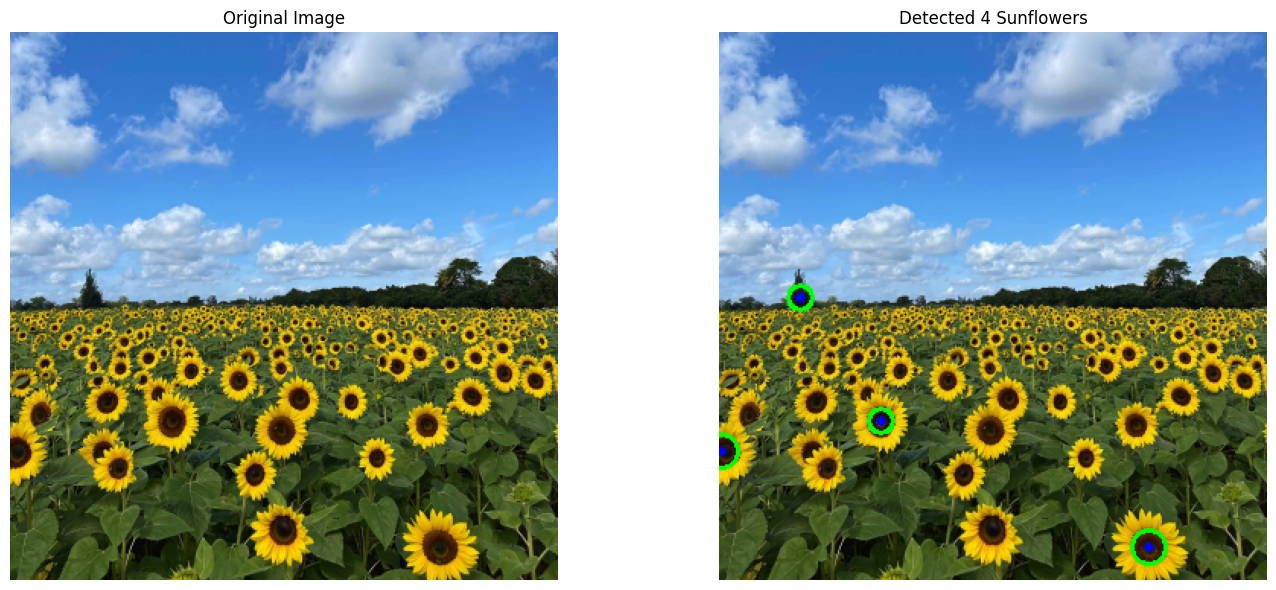


Debug visualization:


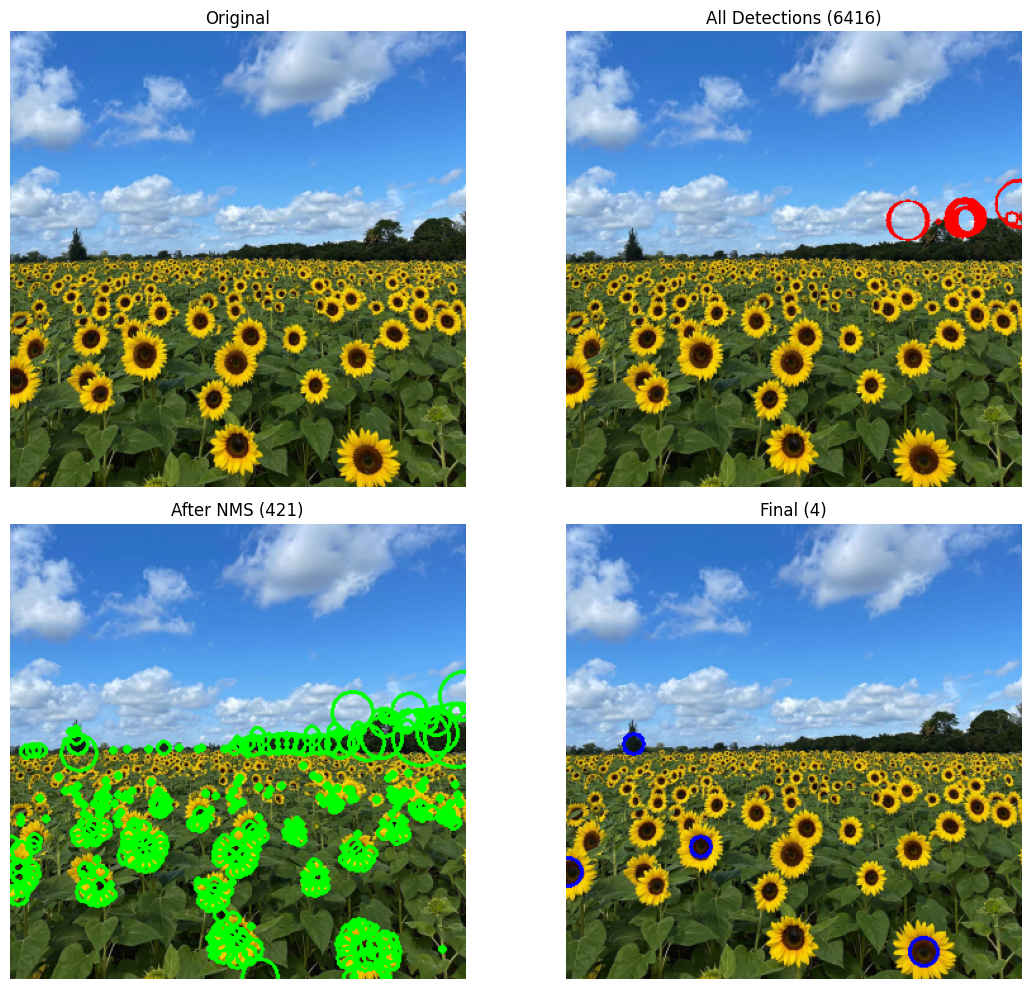

In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
gray = gray.astype(np.float32) / 255.0

# Define scale space parameters
sigma_start = 2
sigma_end = 20
num_scales = 10
sigma_values = np.linspace(sigma_start, sigma_end, num_scales)

# Create scale-space (LoG responses)
h, w = gray.shape
log_response = np.zeros((h, w, num_scales), dtype=np.float32)

for i, sigma in enumerate(sigma_values):
    # Apply Gaussian Blur
    ksize = int(6 * sigma + 1)
    blur = cv.GaussianBlur(gray, (ksize, ksize), sigma)
    
    # Laplacian of Gaussian approximation
    log = cv.Laplacian(blur, cv.CV_32F, ksize=3)
    
    # Normalize scale (multiply by sigma^2)
    log_response[:, :, i] = (sigma ** 2) * np.abs(log)

# Find scale-space maxima with better thresholding
max_resp = np.max(log_response, axis=2)
# Use percentile-based threshold instead of fixed value
threshold = np.percentile(max_resp, 95)  # Only top 5% strongest responses
print(f"Adaptive threshold: {threshold:.4f}")

blobs = []
for y in range(1, h - 1):
    for x in range(1, w - 1):
        val = max_resp[y, x]
        if val > threshold:
            scale_idx = np.argmax(log_response[y, x, :])
            sigma = sigma_values[scale_idx]
            blobs.append((x, y, sigma, val))

print(f"Found {len(blobs)} potential blobs")

# IMPROVED NON-MAXIMUM SUPPRESSION
def non_maximum_suppression(blobs, min_distance_ratio=0.5):
    """
    Better NMS that groups nearby detections and keeps the best one per flower
    """
    if not blobs:
        return []
    
    # Sort by response strength (strongest first)
    blobs_sorted = sorted(blobs, key=lambda x: x[3], reverse=True)
    
    suppressed = []
    used_positions = []
    
    for blob in blobs_sorted:
        x, y, sigma, response = blob
        radius = np.sqrt(2) * sigma
        
        # Check if this blob is too close to any already selected blob
        too_close = False
        for used_x, used_y, used_sigma, used_response in used_positions:
            used_radius = np.sqrt(2) * used_sigma
            distance = np.sqrt((x - used_x)**2 + (y - used_y)**2)
            
            # If centers are closer than the average radius, skip
            min_radius = min(radius, used_radius)
            if distance < min_radius * min_distance_ratio:
                too_close = True
                break
        
        if not too_close:
            suppressed.append(blob)
            used_positions.append((x, y, sigma, response))
    
    return suppressed

# Apply improved NMS
filtered_blobs = non_maximum_suppression(blobs, min_distance_ratio=0.8)
print(f"After NMS: {len(filtered_blobs)} blobs")

# CLUSTER-BASED GROUPING (for overlapping detections)
def cluster_blobs(blobs, eps=15, min_samples=1):
    """
    Use DBSCAN to group nearby detections and return cluster centers
    """
    if len(blobs) == 0:
        return []
    
    # Extract coordinates
    coordinates = np.array([[x, y] for x, y, sigma, response in blobs])
    
    # Cluster nearby points
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates)
    labels = clustering.labels_
    
    clustered_blobs = []
    
    # For each cluster, take the strongest detection
    for cluster_id in set(labels):
        if cluster_id == -1:  # Noise points
            continue
            
        cluster_indices = np.where(labels == cluster_id)[0]
        cluster_blobs = [blobs[i] for i in cluster_indices]
        
        # Take the blob with strongest response
        best_blob = max(cluster_blobs, key=lambda x: x[3])
        clustered_blobs.append(best_blob)
    
    return clustered_blobs

# Apply clustering
final_blobs = cluster_blobs(filtered_blobs, eps=20)
print(f"After clustering: {len(final_blobs)} final sunflowers")

# SIZE-BASED FILTERING (sunflowers should be within reasonable size range)
def filter_by_size(blobs, min_radius=8, max_radius=40):
    filtered = []
    for x, y, sigma, response in blobs:
        radius = np.sqrt(2) * sigma
        if min_radius <= radius <= max_radius:
            filtered.append((x, y, sigma, response))
    return filtered

final_blobs = filter_by_size(final_blobs)
print(f"After size filtering: {len(final_blobs)} sunflowers")

# Draw circles on the image
output = im.copy()
for (x, y, sigma, response) in final_blobs:
    r = int(np.sqrt(2) * sigma)
    cv.circle(output, (int(x), int(y)), r, (0, 255, 0), 2)  # Green circle
    cv.circle(output, (int(x), int(y)), 3, (255, 0, 0), -1)  # Blue center dot

# Sort and report largest circles
final_blobs.sort(key=lambda b: b[2], reverse=True)
largest_circles = final_blobs[:5]

print("\nσ range used:", sigma_start, "to", sigma_end)
print("\nTop 5 largest sunflowers:")
print("Rank | Center (x,y) | Radius | Response")
print("-" * 45)
for i, (x, y, sigma, response) in enumerate(largest_circles):
    radius = np.sqrt(2) * sigma
    print(f"{i+1:4d} | ({x:5.1f}, {y:5.1f}) | {radius:6.1f} | {response:.4f}")

# Display results with comparison
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
plt.title(f"Detected {len(final_blobs)} Sunflowers")
plt.axis("off")

plt.tight_layout()
plt.show()

# DEBUG: Show different stages
def debug_visualization(original, all_blobs, nms_blobs, final_blobs):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Original
    axes[0,0].imshow(cv.cvtColor(original, cv.COLOR_BGR2RGB))
    axes[0,0].set_title("Original")
    axes[0,0].axis('off')
    
    # All detections
    img_all = original.copy()
    for x, y, sigma, response in all_blobs[:50]:  # Show first 50 to avoid clutter
        r = int(np.sqrt(2) * sigma)
        cv.circle(img_all, (int(x), int(y)), r, (0, 0, 255), 1)
    axes[0,1].imshow(cv.cvtColor(img_all, cv.COLOR_BGR2RGB))
    axes[0,1].set_title(f"All Detections ({len(all_blobs)})")
    axes[0,1].axis('off')
    
    # After NMS
    img_nms = original.copy()
    for x, y, sigma, response in nms_blobs:
        r = int(np.sqrt(2) * sigma)
        cv.circle(img_nms, (int(x), int(y)), r, (0, 255, 0), 2)
    axes[1,0].imshow(cv.cvtColor(img_nms, cv.COLOR_BGR2RGB))
    axes[1,0].set_title(f"After NMS ({len(nms_blobs)})")
    axes[1,0].axis('off')
    
    # Final
    img_final = original.copy()
    for x, y, sigma, response in final_blobs:
        r = int(np.sqrt(2) * sigma)
        cv.circle(img_final, (int(x), int(y)), r, (255, 0, 0), 2)
    axes[1,1].imshow(cv.cvtColor(img_final, cv.COLOR_BGR2RGB))
    axes[1,1].set_title(f"Final ({len(final_blobs)})")
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()

print("\nDebug visualization:")
debug_visualization(im, blobs, filtered_blobs, final_blobs)

Image size: (360, 360)
Sigma values: [ 2.          2.68421053  3.36842105  4.05263158  4.73684211  5.42105263
  6.10526316  6.78947368  7.47368421  8.15789474  8.84210526  9.52631579
 10.21052632 10.89473684 11.57894737 12.26315789 12.94736842 13.63157895
 14.31578947 15.        ]
Processing sigma = 2.00
Processing sigma = 2.68
Processing sigma = 3.37
Processing sigma = 4.05
Processing sigma = 4.74
Processing sigma = 5.42
Processing sigma = 6.11
Processing sigma = 6.79
Processing sigma = 7.47
Processing sigma = 8.16
Processing sigma = 8.84
Processing sigma = 9.53
Processing sigma = 10.21
Processing sigma = 10.89
Processing sigma = 11.58
Processing sigma = 12.26
Processing sigma = 12.95
Processing sigma = 13.63
Processing sigma = 14.32
Processing sigma = 15.00
Finding minima for sigma=2.00
Finding minima for sigma=2.68
Finding minima for sigma=3.37
Finding minima for sigma=4.05
Finding minima for sigma=4.74
Finding minima for sigma=5.42
Finding minima for sigma=6.11
Finding minima for s

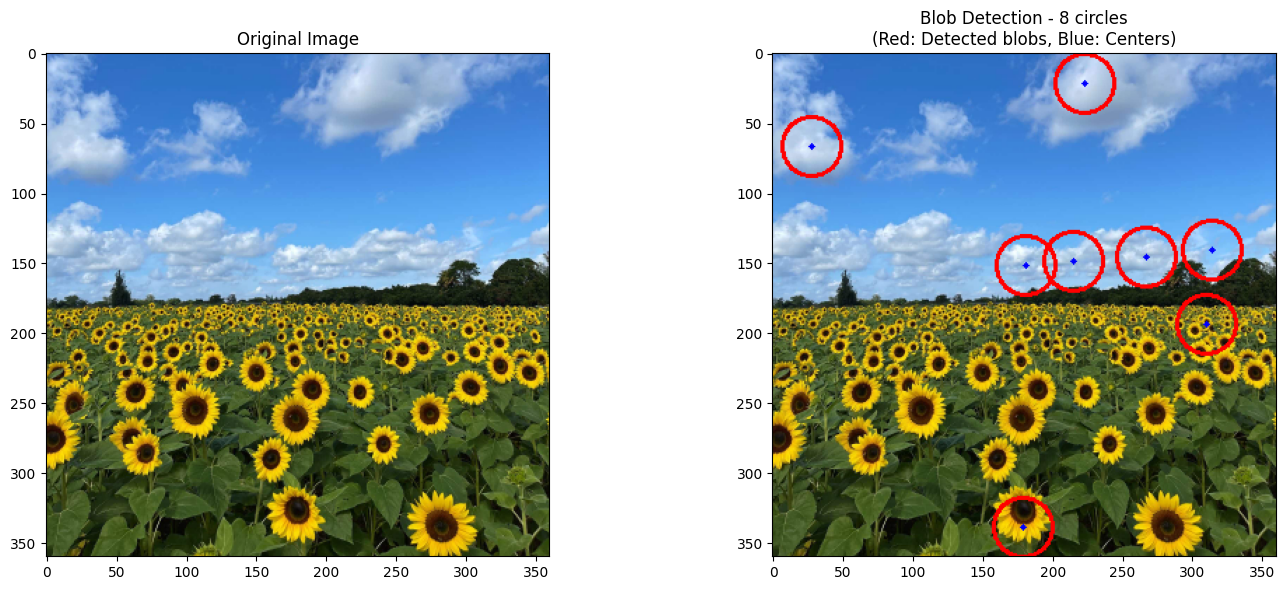


Top 5 largest blobs:
Rank | Center (x,y) | Radius | Sigma | Response
-------------------------------------------------------
   1 | (267.0, 146.0) |  21.21 | 15.00 | -102516.4688
   2 | (314.0, 141.0) |  21.21 | 15.00 | -95487.9141
   3 | ( 28.0,  67.0) |  21.21 | 15.00 | -93087.9375
   4 | (215.0, 149.0) |  21.21 | 15.00 | -90086.2500
   5 | (223.0,  22.0) |  21.21 | 15.00 | -89855.3203

Visualizing LoG kernels...


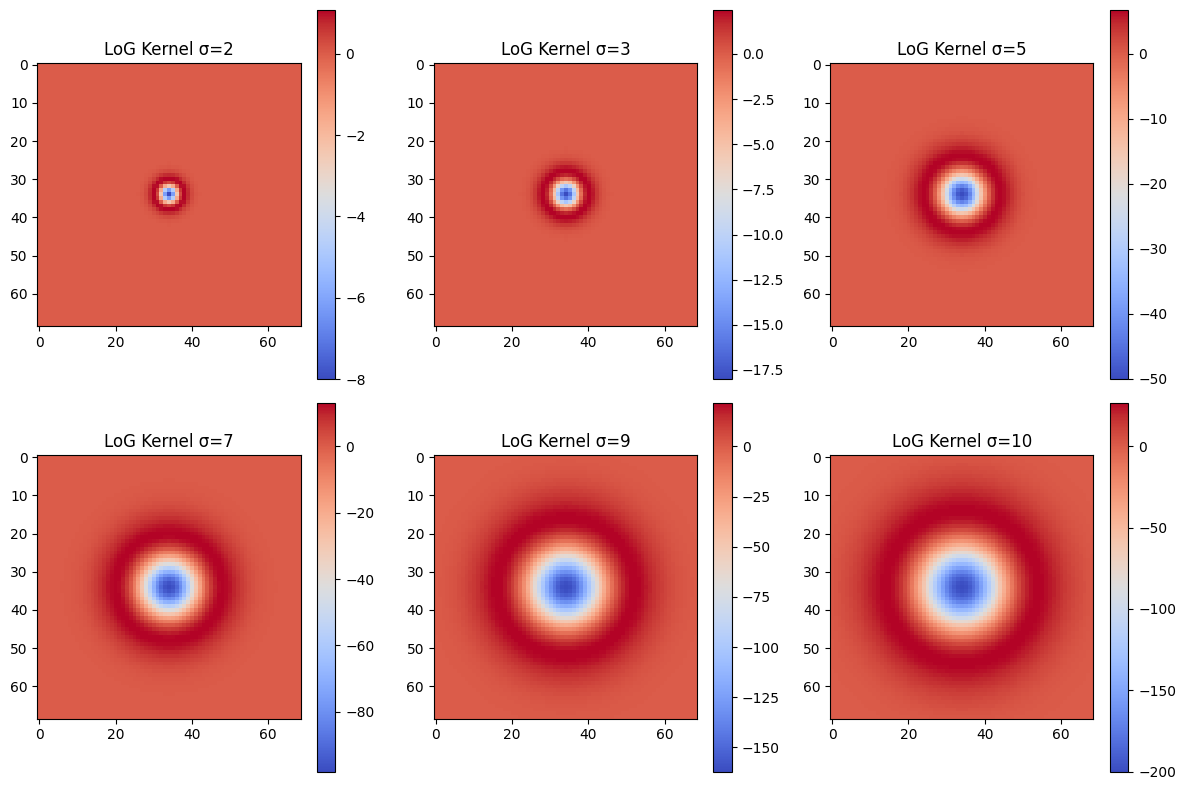

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def create_2d_gaussian_kernel(sigma, size=None):
    """
    Create a 2D Gaussian kernel
    """
    if size is None:
        size = int(6 * sigma) 
        if size % 2 == 0:
            size += 1
        size = max(3, size)
    
    kernel_1d = cv.getGaussianKernel(size, sigma)
    kernel_2d = kernel_1d * kernel_1d.T
    return kernel_2d

def create_laplacian_of_gaussian_kernel(sigma, size=70):
    """
    Create Laplacian of Gaussian kernel and scale by sigma^2
    """
    if size is None:
        size = int(6 * sigma)
        if size % 2 == 0:
            size += 1
        size = max(3, size)
    
    # Create coordinate grid
    k = (size - 1) // 2
    x = np.arange(-k, k + 1)
    y = np.arange(-k, k + 1)
    X, Y = np.meshgrid(x, y)
    
    # Laplacian of Gaussian formula
    r_squared = X**2 + Y**2
    #log_kernel = (-1 / (np.pi * sigma**4)) * (1 - r_squared / (2 * sigma**2)) * np.exp(-r_squared / (2 * sigma**2))
    #log_kernel = (r_squared-2*(sigma**2)) * np.exp(-r_squared / (2 * sigma**2))
    #log_kernel =  (1/(np.sqrt(2*np.pi)*sigma**3))*(r_squared-2*sigma**2) * np.exp(-r_squared / (2 * sigma**2))
    log_kernel =  (r_squared-2*sigma**2) * np.exp(-r_squared / (2 * sigma**2))
    
    # Scale by sigma^2
    #scaled_log_kernel = (sigma ** 2) * log_kernel
    
    return log_kernel

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
gray = gray.astype(np.float32) / 255.0

print(f"Image size: {gray.shape}")

# Step 1: Define sigma values
sigma_start = 2
sigma_end = 15
num_scales = 20
sigma_values = np.linspace(sigma_start, sigma_end, num_scales)

print(f"Sigma values: {sigma_values}")

# Step 2 & 3: Create scaled Laplacian of Gaussian kernels and convolve with image
h, w = gray.shape
scale_space = np.zeros((h, w, num_scales), dtype=np.float32)

for i, sigma in enumerate(sigma_values):
    print(f"Processing sigma = {sigma:.2f}")
    
    # Create scaled Laplacian of Gaussian kernel
    log_kernel = create_laplacian_of_gaussian_kernel(sigma)
    
    # Convolve with image
    response = cv.filter2D(gray, cv.CV_32F, log_kernel)
    
    # Store in scale space
    scale_space[:, :, i] = response

# Step 4: Find minima (dark blobs on light background)
# Since we're looking for dark sunflower centers on bright petals, we want minima
blobs = []

# Search for local minima in 3D scale space
for scale_idx in range(num_scales):
    sigma = sigma_values[scale_idx]
    current_response = scale_space[:, :, scale_idx]
    
    # Radius formula: r = sigma * sqrt(2)
    radius = sigma * np.sqrt(2)
    
    print(f"Finding minima for sigma={sigma:.2f}")
    
    # Find local minima in current scale
    for y in range(int(sigma), h-int(sigma)):
        for x in range(int(sigma), w-int(sigma)):
            current_val = current_response[y, x]
            max_val = -10000
            
            # Check if this is a local minimum in 3x3 neighborhood
            is_minimum = True
            for dy in [-int(sigma), 0, int(sigma)]:
                for dx in [-int(sigma), 0, int(sigma)]:
                    if dy == 0 and dx == 0:
                        continue
                    if current_response[y+dy, x+dx] < current_val:
                        is_minimum = False
                        break
                    if(current_response[y+dy, x+dx] > max_val):
                        max_val = current_response[y+dy, x+dx]
                if not is_minimum:
                    break
            #remove sky
            if(max_val - current_val < 70000):
                is_minimum = False
            
            # Check scale-space: compare with adjacent scales
            #if is_minimum and scale_idx > 0:
            #    if current_response[y, x] > scale_space[y, x, scale_idx-1]:
            #        is_minimum = False
            
            #if is_minimum and scale_idx < num_scales-1:
            #    if current_response[y, x] > scale_space[y, x, scale_idx+1]:
            #        is_minimum = False
            
            # If it's a strong enough minimum (very negative)
            if is_minimum: #and current_val < -0.01:  # Adjust threshold as needed
                blobs.append((x, y, radius, sigma, current_val))

print(f"Found {len(blobs)} blob candidates")

# Remove duplicates - keep the strongest response for each location
final_blobs = []
used_locations = set()

# Sort by response strength (most negative first)
blobs.sort(key=lambda x: x[4])

for blob in blobs:
    x, y, radius, sigma, response = blob
    
    # Check if this location is already used
    location_used = False
    for used_x, used_y, used_r, _, _ in final_blobs:
        distance = np.sqrt((x - used_x)**2 + (y - used_y)**2)
        if distance < min(radius, used_r):
            location_used = True
            break
    
    if not location_used:
        final_blobs.append(blob)
        used_locations.add((x, y))

print(f"After duplicate removal: {len(final_blobs)} blobs")

# Step 5: Draw circles on output image
output = im.copy()

# Sort by radius (largest first) for visualization
final_blobs.sort(key=lambda x: x[2], reverse=True)

# Draw all detected blobs
for i, (x, y, radius, sigma, response) in enumerate(final_blobs):
    # Convert radius to integer for drawing
    r = int(radius)
    
    # Draw circle
    cv.circle(output, (int(x), int(y)), r, (0, 0, 255), 2)
    
    # Draw center point
    cv.circle(output, (int(x), int(y)), 2, (255, 0, 0), -1)
    
    # Only show first 20 to avoid clutter
    if i >= 20:
        break

# Display results
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
plt.title("Original Image")
#plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
plt.title(f"Blob Detection - {len(final_blobs)} circles\n(Red: Detected blobs, Blue: Centers)")
#plt.axis('off')

plt.tight_layout()
plt.show()

# Report largest circles
if final_blobs:
    print(f"\nTop 5 largest blobs:")
    print("Rank | Center (x,y) | Radius | Sigma | Response")
    print("-" * 55)
    for i, (x, y, radius, sigma, response) in enumerate(final_blobs[:5]):
        print(f"{i+1:4d} | ({x:5.1f}, {y:5.1f}) | {radius:6.2f} | {sigma:5.2f} | {response:.4f}")

# Optional: Visualize LoG kernels
print(f"\nVisualizing LoG kernels...")
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
sample_sigmas = [2, 3, 5, 7, 9, 10]

for i, sigma in enumerate(sample_sigmas):
    if i < 6:
        kernel = create_laplacian_of_gaussian_kernel(sigma)
        ax = axes[i//3, i%3]
        im_plot = ax.imshow(kernel, cmap='coolwarm')
        ax.set_title(f'LoG Kernel σ={sigma}')
        #ax.axis('off')
        plt.colorbar(im_plot, ax=ax)

plt.tight_layout()
plt.show()

Image size: (360, 360)
Radii: [ 6  7  8  9 10 11 12 13 14 15]
Sigma values: [ 4.24264069  4.94974747  5.65685425  6.36396103  7.07106781  7.77817459
  8.48528137  9.19238816  9.89949494 10.60660172]
Processing sigma = 4.24 (radius = 6)
Processing sigma = 4.95 (radius = 7)
Processing sigma = 5.66 (radius = 8)
Processing sigma = 6.36 (radius = 9)
Processing sigma = 7.07 (radius = 10)
Processing sigma = 7.78 (radius = 11)
Processing sigma = 8.49 (radius = 12)
Processing sigma = 9.19 (radius = 13)
Processing sigma = 9.90 (radius = 14)
Processing sigma = 10.61 (radius = 15)
Finding maxima for radius=6, sigma=4.24
Finding maxima for radius=7, sigma=4.95
Finding maxima for radius=8, sigma=5.66
Finding maxima for radius=9, sigma=6.36
Finding maxima for radius=10, sigma=7.07
Finding maxima for radius=11, sigma=7.78
Finding maxima for radius=12, sigma=8.49
Finding maxima for radius=13, sigma=9.19
Finding maxima for radius=14, sigma=9.90
Finding maxima for radius=15, sigma=10.61
Found 361 blob ca

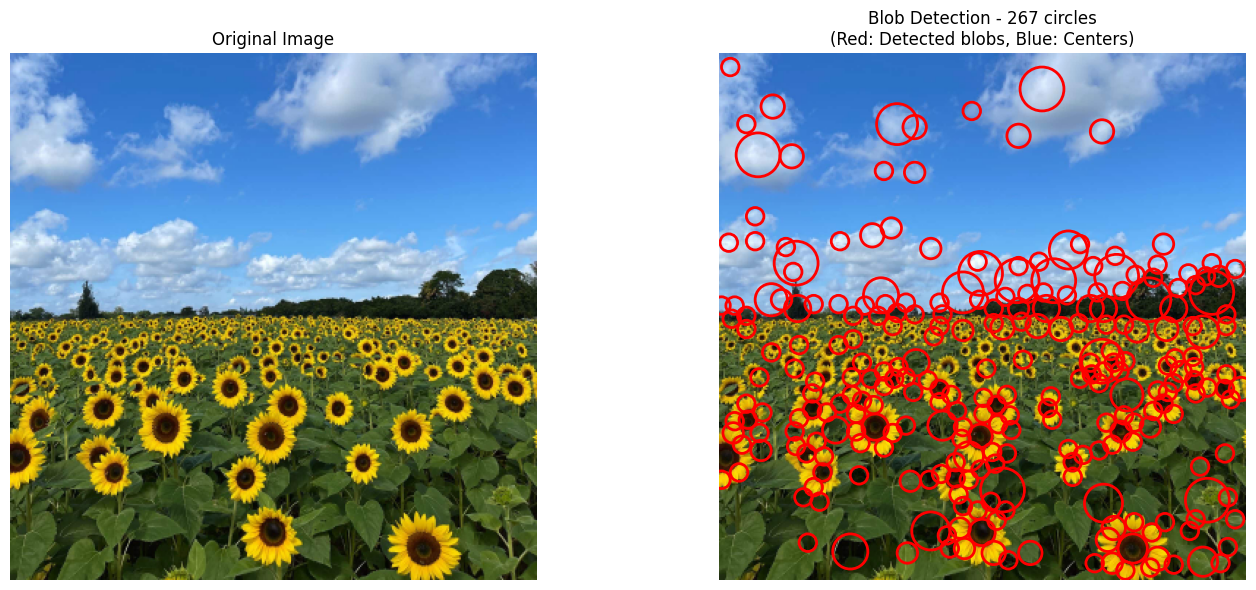


Top 5 largest blobs:
Rank | Center (x,y) | Radius | Sigma | Response
-------------------------------------------------------
   1 | (303.0, 239.0) |    6.0 |  4.24 | 0.1253
   2 | (106.0, 255.0) |    9.0 |  6.36 | 0.1174
   3 | (161.0, 290.0) |    6.0 |  4.24 | 0.1168
   4 | (241.0, 279.0) |    6.0 |  4.24 | 0.1152
   5 | (150.0, 229.0) |    6.0 |  4.24 | 0.1140

Visualizing LoG kernels...


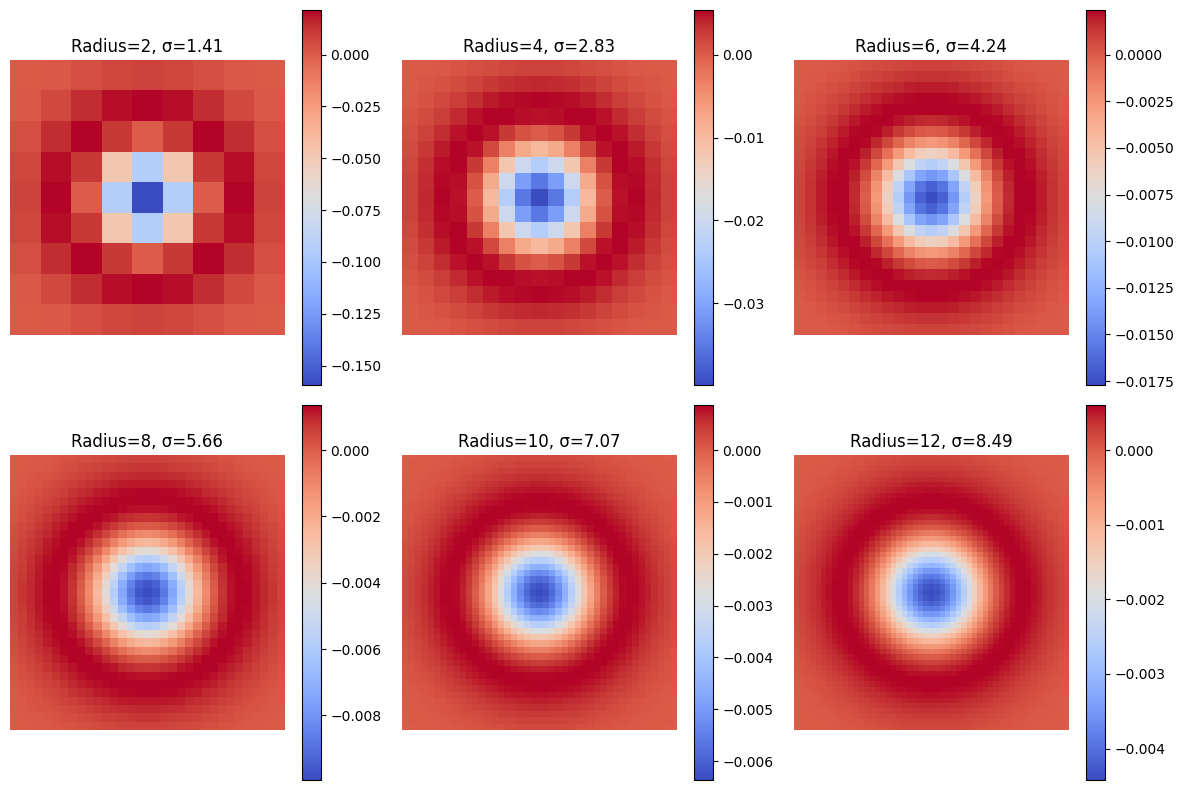


Visualizing responses at different scales...


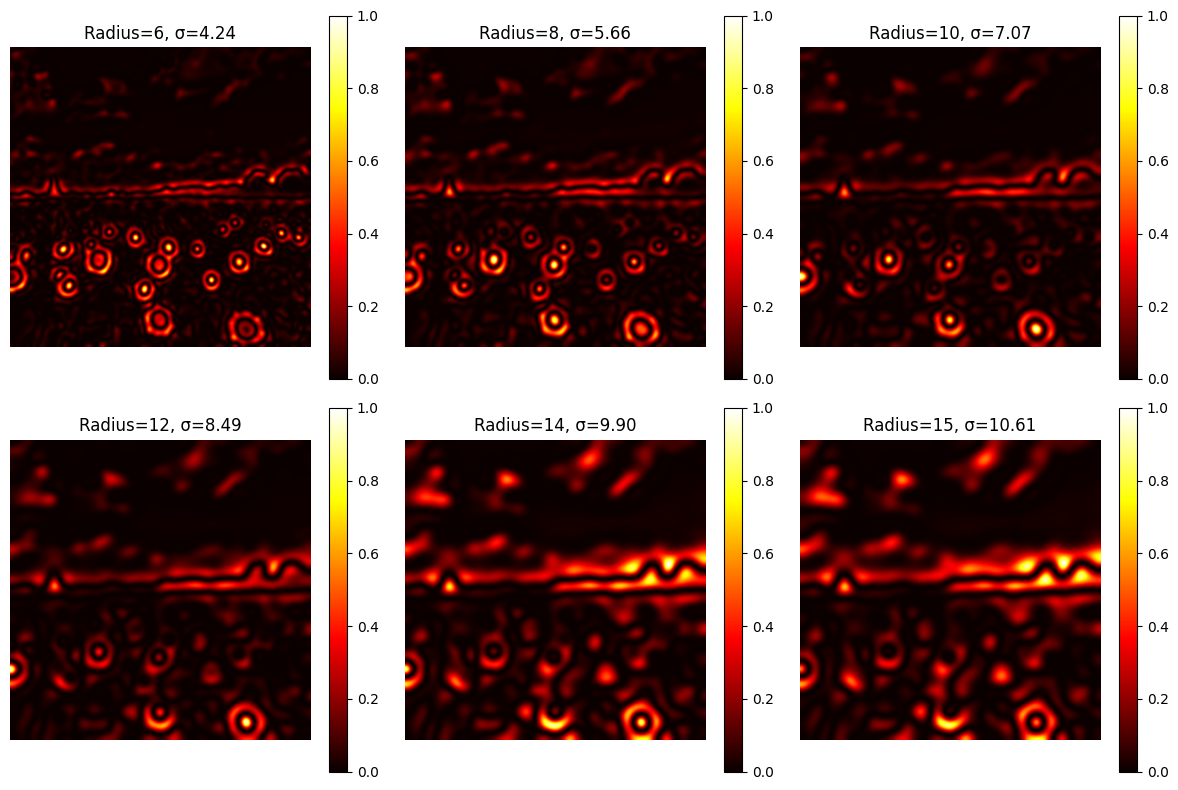

In [71]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def create_laplacian_of_gaussian_kernel(sigma):
    """
    Create CORRECT Laplacian of Gaussian kernel with proper normalization
    """
    # Determine kernel size (standard: 6*sigma)
    hw = int(3 * sigma)  # Half width
    size = 2 * hw + 1    # Ensure odd size
    
    # Create coordinate grid
    x = np.arange(-hw, hw + 1)
    y = np.arange(-hw, hw + 1)
    X, Y = np.meshgrid(x, y)
    
    # CORRECT Laplacian of Gaussian formula
    r_squared = X**2 + Y**2
    log_kernel = ((r_squared) / (2 * sigma**2) - 1) * np.exp(-r_squared / (2 * sigma**2)) / (np.pi * sigma**4)
    
    # Scale by sigma^2 for scale invariance
    scaled_log_kernel = (sigma ** 2) * log_kernel
    
    return scaled_log_kernel

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
gray = gray.astype(np.float32) / 255.0

print(f"Image size: {gray.shape}")

# Step 1: Define sigma values (now representing radii)
radius_start = 6
radius_end = 15
num_scales = 10
radii = np.arange(radius_start, radius_end + 1)
sigma_values = radii / np.sqrt(2)  # Convert radius to sigma: σ = r/√2

print(f"Radii: {radii}")
print(f"Sigma values: {sigma_values}")

# Step 2 & 3: Create scaled Laplacian of Gaussian kernels and convolve with image
h, w = gray.shape
scale_space = np.zeros((h, w, num_scales), dtype=np.float32)

for i, sigma in enumerate(sigma_values):
    print(f"Processing sigma = {sigma:.2f} (radius = {radii[i]})")
    
    # Create CORRECT scaled Laplacian of Gaussian kernel
    log_kernel = create_laplacian_of_gaussian_kernel(sigma)
    
    # Convolve with image and SQUARE the response
    response = cv.filter2D(gray, cv.CV_32F, log_kernel)
    squared_response = np.square(response)  # Make all responses positive
    
    # Store in scale space
    scale_space[:, :, i] = squared_response

# Step 4: Find LOCAL MAXIMA (not minima) in scale-space
blobs = []

# Search for local maxima in 3D scale space
for scale_idx in range(num_scales):
    sigma = sigma_values[scale_idx]
    radius = radii[scale_idx]  # Direct radius value
    current_response = scale_space[:, :, scale_idx]
    
    print(f"Finding maxima for radius={radius}, sigma={sigma:.2f}")
    
    # SIMPLE neighborhood search (3x3)
    k = 1  # Neighborhood size
    threshold = 0.01  # Adjust based on your image
    
    for y in range(k, h - k):
        for x in range(k, w - k):
            current_val = current_response[y, x]
            
            # Skip if below threshold
            if current_val < threshold:
                continue
            
            # Check if this is a local maximum in 3x3 neighborhood
            is_maximum = True
            for dy in range(-k, k + 1):
                for dx in range(-k, k + 1):
                    if dy == 0 and dx == 0:
                        continue
                    if current_response[y + dy, x + dx] > current_val:
                        is_maximum = False
                        break
                if not is_maximum:
                    break
            
            # Check scale-space: compare with adjacent scales
            if is_maximum and scale_idx > 0:
                if current_val < scale_space[y, x, scale_idx - 1]:
                    is_maximum = False
            
            if is_maximum and scale_idx < num_scales - 1:
                if current_val < scale_space[y, x, scale_idx + 1]:
                    is_maximum = False
            
            # If it's a true 3D maximum, record it
            if is_maximum:
                blobs.append((x, y, radius, sigma, current_val))

print(f"Found {len(blobs)} blob candidates")

# Remove duplicates - keep the strongest response for each location
final_blobs = []

# Sort by response strength (strongest first)
blobs.sort(key=lambda x: x[4], reverse=True)

for blob in blobs:
    x, y, radius, sigma, response = blob
    
    # Check if this location is already used
    location_used = False
    for existing_x, existing_y, existing_radius, _, _ in final_blobs:
        distance = np.sqrt((x - existing_x)**2 + (y - existing_y)**2)
        # If centers are closer than the smaller radius, skip
        if distance < min(radius, existing_radius):
            location_used = True
            break
    
    if not location_used:
        final_blobs.append(blob)

print(f"After duplicate removal: {len(final_blobs)} blobs")

# Step 5: Draw circles on output image using matplotlib
plt.figure(figsize=(15, 6))

# Create subplot for original image
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Create subplot for detected blobs
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
ax = plt.gca()

# Draw all detected blobs
for i, (x, y, radius, sigma, response) in enumerate(final_blobs):
    # Draw circle
    circle = plt.Circle((x, y), radius, color='red', linewidth=2, fill=False)
    ax.add_patch(circle)
    
    # Draw center point
    #plt.plot(x, y, 'b+', markersize=8, markeredgewidth=2)

plt.title(f"Blob Detection - {len(final_blobs)} circles\n(Red: Detected blobs, Blue: Centers)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Report results
if final_blobs:
    print(f"\nTop 5 largest blobs:")
    print("Rank | Center (x,y) | Radius | Sigma | Response")
    print("-" * 55)
    for i, (x, y, radius, sigma, response) in enumerate(final_blobs[:5]):
        print(f"{i+1:4d} | ({x:5.1f}, {y:5.1f}) | {radius:6.1f} | {sigma:5.2f} | {response:.4f}")

# Optional: Visualize LoG kernels for different scales
print(f"\nVisualizing LoG kernels...")
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
sample_radii = [2, 4, 6, 8, 10, 12]  # Sample radii to visualize
sample_sigmas = [r / np.sqrt(2) for r in sample_radii]

for i, (radius, sigma) in enumerate(zip(sample_radii, sample_sigmas)):
    if i < 6:
        kernel = create_laplacian_of_gaussian_kernel(sigma)
        ax = axes[i//3, i%3]
        im_plot = ax.imshow(kernel, cmap='coolwarm')
        ax.set_title(f'Radius={radius}, σ={sigma:.2f}')
        ax.axis('off')
        plt.colorbar(im_plot, ax=ax)

plt.tight_layout()
plt.show()

# Additional: Show response images at different scales
print(f"\nVisualizing responses at different scales...")
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
sample_scale_indices = [0, 2, 4, 6, 8, 9]  # Sample scales to visualize

for i, scale_idx in enumerate(sample_scale_indices):
    if i < 6:
        ax = axes[i//3, i%3]
        response_img = scale_space[:, :, scale_idx]
        # Normalize for visualization
        response_normalized = (response_img - response_img.min()) / (response_img.max() - response_img.min())
        im_plot = ax.imshow(response_normalized, cmap='hot')
        ax.set_title(f'Radius={radii[scale_idx]}, σ={sigma_values[scale_idx]:.2f}')
        ax.axis('off')
        plt.colorbar(im_plot, ax=ax)

plt.tight_layout()
plt.show()

Image size: (360, 360)
Radii: [2 3 4 5 6 7 8 9]
Sigma values: [1.41421356 2.12132034 2.82842712 3.53553391 4.24264069 4.94974747
 5.65685425 6.36396103]
Processing sigma = 1.41 (radius = 2)
Processing sigma = 2.12 (radius = 3)
Processing sigma = 2.83 (radius = 4)
Processing sigma = 3.54 (radius = 5)
Processing sigma = 4.24 (radius = 6)
Processing sigma = 4.95 (radius = 7)
Processing sigma = 5.66 (radius = 8)
Processing sigma = 6.36 (radius = 9)
Finding maxima for radius=2, sigma=1.41
Finding maxima for radius=3, sigma=2.12
Finding maxima for radius=4, sigma=2.83
Finding maxima for radius=5, sigma=3.54
Finding maxima for radius=6, sigma=4.24
Finding maxima for radius=7, sigma=4.95
Finding maxima for radius=8, sigma=5.66
Finding maxima for radius=9, sigma=6.36
Found 52 blob candidates
After duplicate removal: 52 blobs


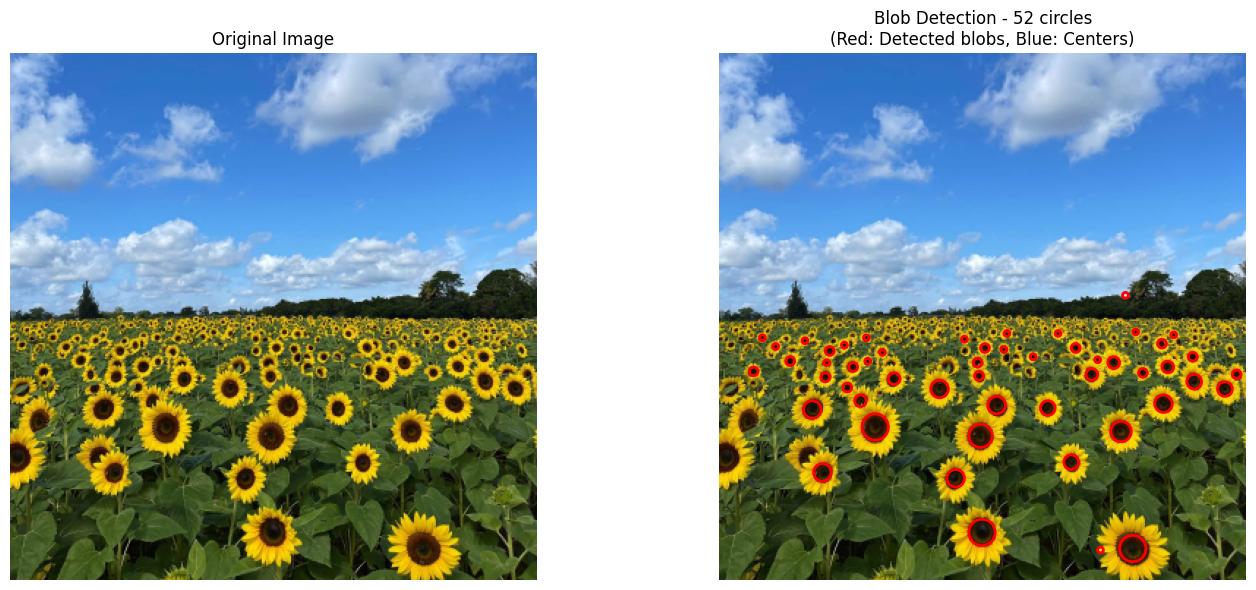


Top 5 largest blobs:
Rank | Center (x,y) | Radius | Sigma | Response
-------------------------------------------------------
   1 | (258.0, 209.0) |    2.0 |  1.41 | 0.1447
   2 | (323.0, 207.0) |    3.0 |  2.12 | 0.1433
   3 | (269.0, 211.0) |    4.0 |  2.83 | 0.1368
   4 | (306.0, 214.0) |    4.0 |  2.83 | 0.1271
   5 | (119.0, 222.0) |    4.0 |  2.83 | 0.1268

Visualizing LoG kernels...


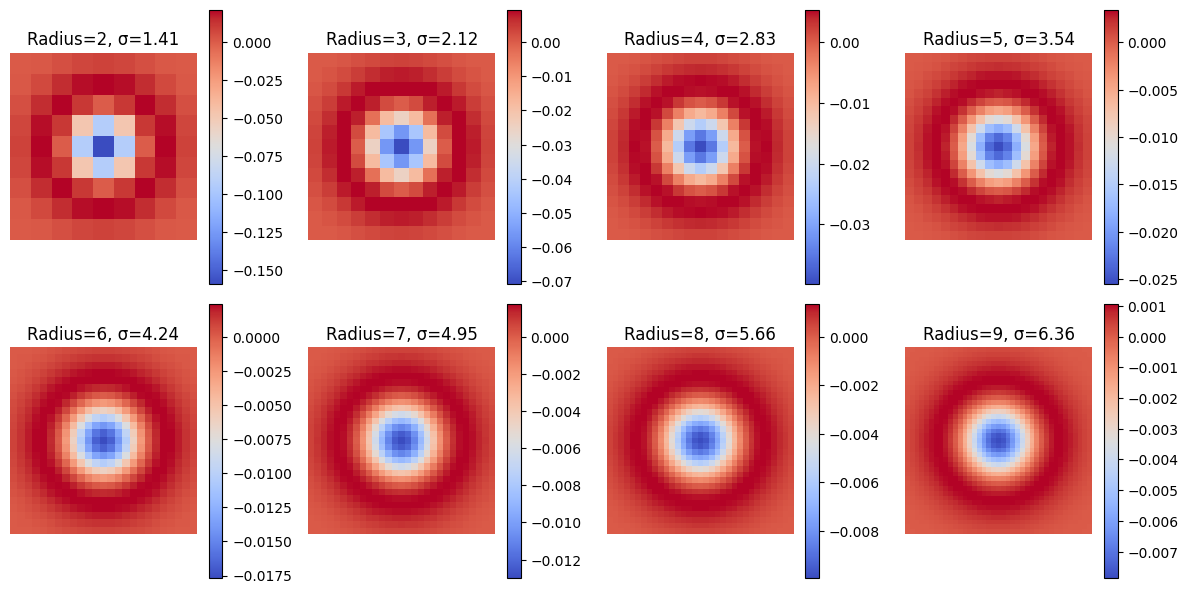


Visualizing responses at different scales...


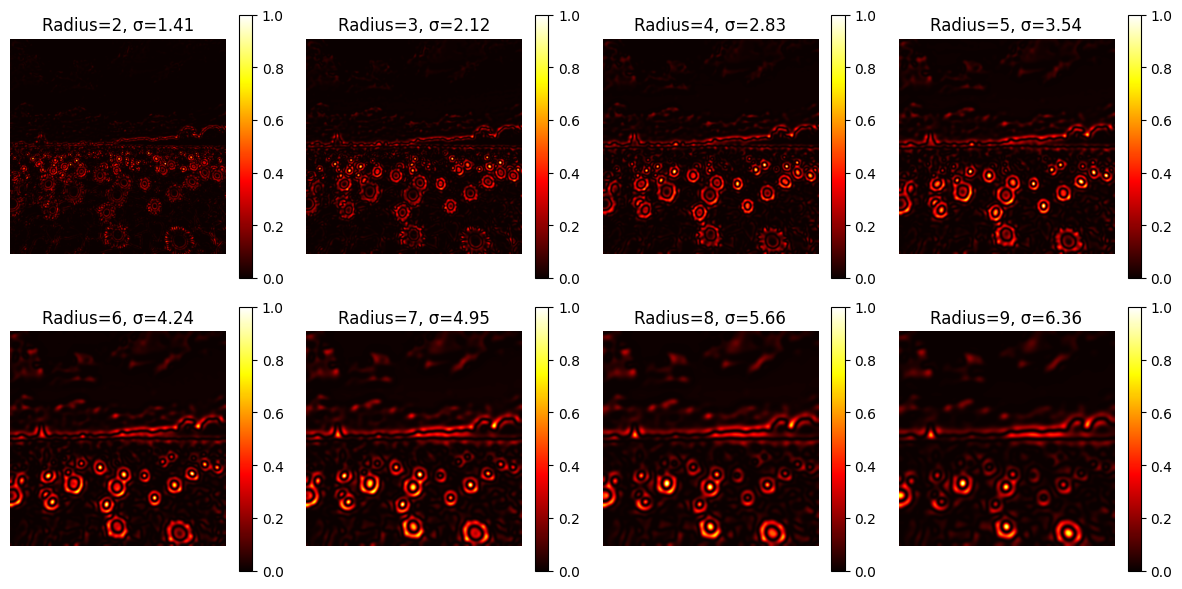

In [89]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def create_laplacian_of_gaussian_kernel(sigma):
    """
    Create CORRECT Laplacian of Gaussian kernel with proper normalization
    """
    # Determine kernel size (standard: 6*sigma)
    hw = int(3 * sigma)  # Half width
    size = 2 * hw + 1    # Ensure odd size
    
    # Create coordinate grid
    x = np.arange(-hw, hw + 1)
    y = np.arange(-hw, hw + 1)
    X, Y = np.meshgrid(x, y)
    
    # CORRECT Laplacian of Gaussian formula
    r_squared = X**2 + Y**2
    log_kernel = ((r_squared) / (2 * sigma**2) - 1) * np.exp(-r_squared / (2 * sigma**2)) / (np.pi * sigma**4)
    
    # Scale by sigma^2 for scale invariance
    scaled_log_kernel = (sigma ** 2) * log_kernel
    
    return scaled_log_kernel

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
gray = gray.astype(np.float32) / 255.0

print(f"Image size: {gray.shape}")

# Step 1: Define sigma values (now representing radii) - CHANGED TO 6-10
radius_start = 2
radius_end = 9  # CHANGED FROM 15 TO 10
num_scales = radius_end-radius_start+1   # CHANGED FROM 10 TO 5 (since we have fewer radii)
radii = np.arange(radius_start, radius_end + 1)
sigma_values = radii / np.sqrt(2)  # Convert radius to sigma: σ = r/√2

print(f"Radii: {radii}")
print(f"Sigma values: {sigma_values}")

# Step 2 & 3: Create scaled Laplacian of Gaussian kernels and convolve with image
h, w = gray.shape
scale_space = np.zeros((h, w, num_scales), dtype=np.float32)

for i, sigma in enumerate(sigma_values):
    print(f"Processing sigma = {sigma:.2f} (radius = {radii[i]})")
    
    # Create CORRECT scaled Laplacian of Gaussian kernel
    log_kernel = create_laplacian_of_gaussian_kernel(sigma)
    
    # Convolve with image and SQUARE the response
    response = cv.filter2D(gray, cv.CV_32F, log_kernel)
    squared_response = np.square(response)  # Make all responses positive
    
    # Store in scale space
    scale_space[:, :, i] = squared_response

# Step 4: Find LOCAL MAXIMA (not minima) in scale-space
blobs = []

# Search for local maxima in 3D scale space
for scale_idx in range(num_scales):
    sigma = sigma_values[scale_idx]
    radius = radii[scale_idx]  # Direct radius value
    current_response = scale_space[:, :, scale_idx]
    
    print(f"Finding maxima for radius={radius}, sigma={sigma:.2f}")
    
    # SIMPLE neighborhood search (3x3)
    k = 1  # Neighborhood size
    
    # NEW: Calculate adaptive threshold for each scale
    # Use percentile to automatically set threshold (removes sky blobs)
    scale_threshold = np.percentile(current_response, 99.97)  # Top 5% strongest responses
    
    for y in range(k, h - k):
        for x in range(k, w - k):
            current_val = current_response[y, x]
            
            # Skip if below threshold - NEW CONDITION TO REMOVE SKY BLOBS
            if current_val < scale_threshold:  # CHANGED FROM FIXED TO ADAPTIVE THRESHOLD
                continue
            
            # Check if this is a local maximum in 3x3 neighborhood
            is_maximum = True
            for dy in range(-k, k + 1):
                for dx in range(-k, k + 1):
                    if dy == 0 and dx == 0:
                        continue
                    if current_response[y + dy, x + dx] > current_val:
                        is_maximum = False
                        break
                if not is_maximum:
                    break
            
            # Check scale-space: compare with adjacent scales
            if is_maximum and scale_idx > 0:
                if current_val < scale_space[y, x, scale_idx - 1]:
                    is_maximum = False
            
            if is_maximum and scale_idx < num_scales - 1:
                if current_val < scale_space[y, x, scale_idx + 1]:
                    is_maximum = False
            
            # If it's a true 3D maximum, record it
            if is_maximum:
                blobs.append((x, y, radius, sigma, current_val))

print(f"Found {len(blobs)} blob candidates")

# Remove duplicates - keep the strongest response for each location
final_blobs = []

# Sort by response strength (strongest first)
blobs.sort(key=lambda x: x[4], reverse=True)

for blob in blobs:
    x, y, radius, sigma, response = blob
    
    # Check if this location is already used
    location_used = False
    for existing_x, existing_y, existing_radius, _, _ in final_blobs:
        distance = np.sqrt((x - existing_x)**2 + (y - existing_y)**2)
        # If centers are closer than the smaller radius, skip
        if distance < min(radius, existing_radius):
            location_used = True
            break
    
    if not location_used:
        final_blobs.append(blob)

print(f"After duplicate removal: {len(final_blobs)} blobs")

# Step 5: Draw circles on output image using matplotlib
plt.figure(figsize=(15, 6))

# Create subplot for original image
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Create subplot for detected blobs
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
ax = plt.gca()

# Draw all detected blobs
for i, (x, y, radius, sigma, response) in enumerate(final_blobs):
    # Draw circle
    circle = plt.Circle((x, y), radius, color='red', linewidth=2, fill=False)
    ax.add_patch(circle)
    
    # Draw center point
    #plt.plot(x, y, 'b+', markersize=8, markeredgewidth=2)

plt.title(f"Blob Detection - {len(final_blobs)} circles\n(Red: Detected blobs, Blue: Centers)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Report results
if final_blobs:
    print(f"\nTop 5 largest blobs:")
    print("Rank | Center (x,y) | Radius | Sigma | Response")
    print("-" * 55)
    for i, (x, y, radius, sigma, response) in enumerate(final_blobs[:5]):
        print(f"{i+1:4d} | ({x:5.1f}, {y:5.1f}) | {radius:6.1f} | {sigma:5.2f} | {response:.4f}")

# Optional: Visualize LoG kernels for different scales
print(f"\nVisualizing LoG kernels...")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # CHANGED TO 3x3 GRID
sample_radii = radii  # CHANGED TO USE ALL RADII WE ACTUALLY USE
sample_sigmas = sigma_values  # CHANGED TO USE ALL SIGMAS WE ACTUALLY USE

for i, (radius, sigma) in enumerate(zip(sample_radii, sample_sigmas)):
    kernel = create_laplacian_of_gaussian_kernel(sigma)
    ax = axes[i//4, i%4]
    im_plot = ax.imshow(kernel, cmap='coolwarm')
    ax.set_title(f'Radius={radius}, σ={sigma:.2f}')
    ax.axis('off')
    plt.colorbar(im_plot, ax=ax)

# Hide any empty subplots if we have less than 9
for i in range(len(sample_radii)):
    axes[i//4, i%4].axis('off')

plt.tight_layout()
plt.show()

# Additional: Show response images at different scales
print(f"\nVisualizing responses at different scales...")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # CHANGED TO 3x3 GRID
sample_scale_indices = list(range(num_scales))  # CHANGED TO SHOW ALL SCALES

for i, scale_idx in enumerate(sample_scale_indices):
    ax = axes[i//4, i%4]
    response_img = scale_space[:, :, scale_idx]
    # Normalize for visualization
    response_normalized = (response_img - response_img.min()) / (response_img.max() - response_img.min())
    im_plot = ax.imshow(response_normalized, cmap='hot')
    ax.set_title(f'Radius={radii[scale_idx]}, σ={sigma_values[scale_idx]:.2f}')
    ax.axis('off')
    plt.colorbar(im_plot, ax=ax)

# Hide any empty subplots if we have less than 9
for i in range(len(sample_scale_indices)):
    axes[i//4, i%4].axis('off')

plt.tight_layout()
plt.show()